In [1]:
import os
from datetime import datetime
import numpy as np

# Directory containing the .npz files
directory_path = "/discover/nobackup/projects/land_da/Experiment_archive/M21C_land_sweeper_DAv8_M36/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg"

# Initialize dictionaries to store time series data
time_series_data = {"time": []}

# Define species names and groups
species_names = [
    "blank", "SMOS_fit_Tbh_A", "SMOS_fit_Tbh_D", "SMOS_fit_Tbv_A", "SMOS_fit_Tbv_D",
    "SMAP_L1C_Tbh_A", "SMAP_L1C_Tbh_D", "SMAP_L1C_Tbv_A", "SMAP_L1C_Tbv_D",
    "ASCAT_META_SM", "ASCAT_METB_SM", "ASCAT_METC_SM", "MYD10C1", "MOD10C1"
]

species_groups = {
    "SMOS": [1, 2, 3, 4],
    "SMAP": [5, 6, 7, 8],
    "ASCAT": [9, 10, 11],
    "MODIS": [12, 13]
}

# Exclude "blank" from species names
species_time_series = {name: [] for name in species_names if name != "blank"}

cumulative_obs_map = None

# Loop through all .npz files in the directory
for file_name in sorted(os.listdir(directory_path)):
    if file_name.endswith(".npz"):
        try:
            # Parse the time from the file name (e.g., 202303 from LS_DAv8_M36.ens_avg.ldas_ObsFcstAna.summed.202303.npz)
            time_str = file_name.split(".")[-2]
            time = datetime.strptime(time_str, "%Y%m")

            # Load the .npz file
            file_path = os.path.join(directory_path, file_name)
            data = np.load(file_path)

            # Sum across tiles for each species
            species_sum = np.sum(data["obs_cnt"], axis=0)

            # Sum data for each group
            group_sums = {group: np.sum(species_sum[indices]) for group, indices in species_groups.items()}

            # Append the data to the time series for groups
            time_series_data["time"].append(time)
            for group, total in group_sums.items():
                if group not in time_series_data:
                    time_series_data[group] = []
                time_series_data[group].append(total)

            # Append the data to the time series for individual species
            for name, total in zip(species_names, species_sum):
                if name != "blank":
                    species_time_series[name].append(total)


            # Cumulatively sum for each tile/species to create a map of number of obs per tile
            if cumulative_obs_map is None:
                cumulative_obs_map = np.zeros_like(data["obs_cnt"])
            cumulative_obs_map += data["obs_cnt"]

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

# Display the collected time series data for groups
#print("Collected time series data for groups:")
#for group, values in time_series_data.items():
#    print(f"{group}: {values}")

# Display the collected time series data for individual species
#print("\nCollected time series data for individual species:")
#for species, values in species_time_series.items():
#    print(f"{species}: {values}")

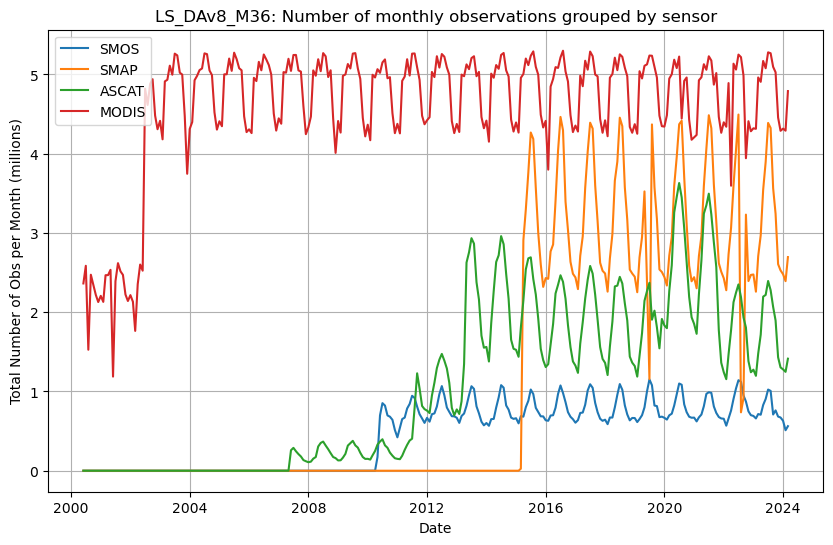

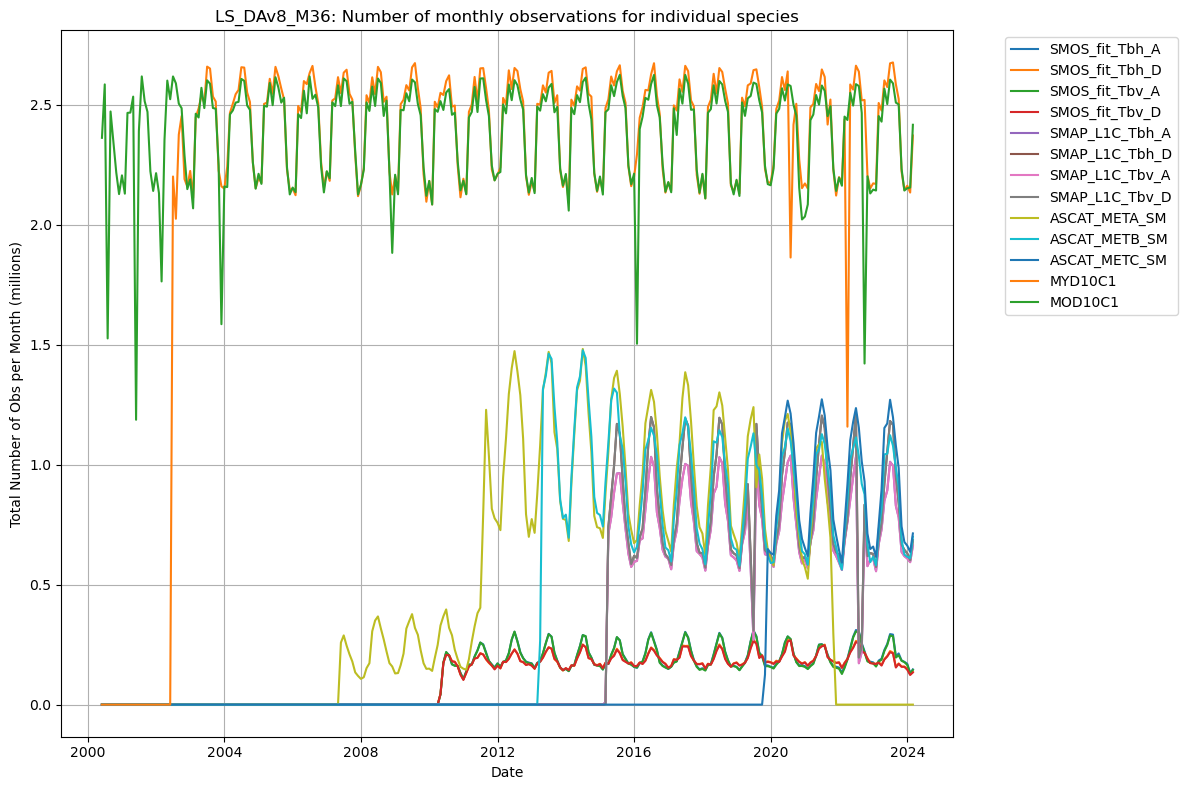

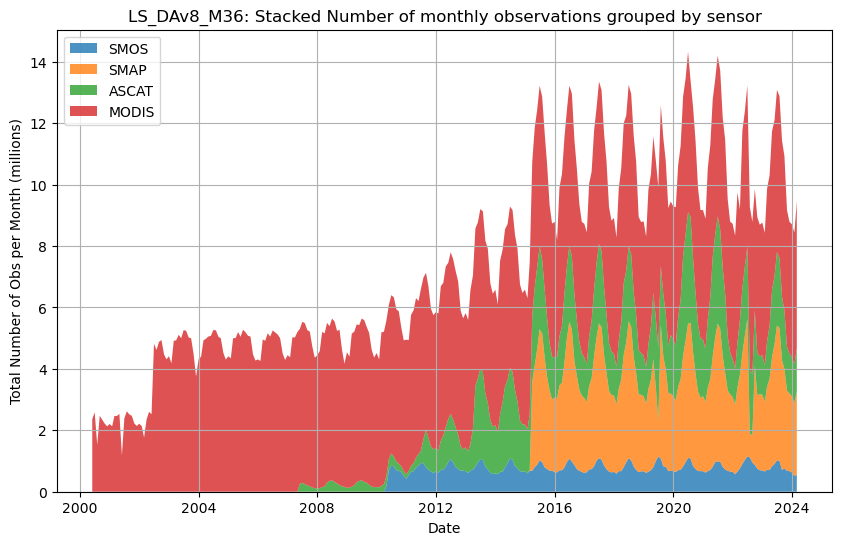

In [2]:
import matplotlib.pyplot as plt

# Exclude the last value in the time series
for key in time_series_data.keys():
    if isinstance(time_series_data[key], list):
        time_series_data[key] = time_series_data[key][:-1]

for key in species_time_series.keys():
    species_time_series[key] = species_time_series[key][:-1]

# Convert time to a sorted list for plotting
sorted_indices = sorted(range(len(time_series_data["time"])), key=lambda i: time_series_data["time"][i])
sorted_time = [time_series_data["time"][i] for i in sorted_indices]

# Plot time series for each group
plt.figure(figsize=(10, 6))
for group in species_groups.keys():
    sorted_values = [time_series_data[group][i] / 1000000 for i in sorted_indices]  # Convert to millions
    plt.plot(sorted_time, sorted_values, label=group)

# Add labels, legend, and title for groups
plt.xlabel("Date")
plt.ylabel("Total Number of Obs per Month (millions)")
plt.title("LS_DAv8_M36: Number of monthly observations grouped by sensor")
plt.legend()
plt.grid(True)
plt.savefig("time_series_groups.png")  # Save the figure
plt.show()

# Plot time series for individual species
plt.figure(figsize=(12, 8))
for species in species_time_series.keys():
    sorted_values = [species_time_series[species][i] / 1000000 for i in sorted_indices]  # Convert to millions
    plt.plot(sorted_time, sorted_values, label=species)

# Add labels, legend, and title for individual species
plt.xlabel("Date")
plt.ylabel("Total Number of Obs per Month (millions)")
plt.title("LS_DAv8_M36: Number of monthly observations for individual species")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("time_series_species.png")  # Save the figure
plt.show()

# Stacked area plot for groups
plt.figure(figsize=(10, 6))

# Prepare data for stacking
stacked_values = np.array([[time_series_data[group][i] / 1000000 for group in species_groups.keys()] for i in sorted_indices]).T  # Convert to millions
labels = list(species_groups.keys())

# Plot stacked area chart
plt.stackplot(sorted_time, stacked_values, labels=labels, alpha=0.8)

# Add labels, legend, and title
plt.xlabel("Date")
plt.ylabel("Total Number of Obs per Month (millions)")
plt.title("LS_DAv8_M36: Stacked Number of monthly observations grouped by sensor")
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig("stacked_area_groups.png")  # Save the figure
plt.show()

In [3]:
from collections import defaultdict
import numpy as np

# Initialize dictionaries to store annual means
annual_means_groups = defaultdict(list)
annual_means_species = defaultdict(list)

# Group data by year
grouped_by_year = defaultdict(lambda: defaultdict(list))
species_grouped_by_year = defaultdict(lambda: defaultdict(list))

for time, group_values, species_values in zip(time_series_data["time"], 
                                              zip(*[time_series_data[group] for group in species_groups.keys()]), 
                                              zip(*[species_time_series[species] for species in species_time_series.keys()])):
    year = time.year
    for group, value in zip(species_groups.keys(), group_values):
        grouped_by_year[year][group].append(value)
    for species, value in zip(species_time_series.keys(), species_values):
        species_grouped_by_year[year][species].append(value)

# Calculate annual means for groups
for year, groups in grouped_by_year.items():
    for group, values in groups.items():
        annual_means_groups[group].append((year, np.mean(values)))

# Calculate annual means for individual species
for year, species in species_grouped_by_year.items():
    for species_name, values in species.items():
        annual_means_species[species_name].append((year, np.mean(values)))

# Display annual means for groups
print("Annual means for groups:")
for group, means in annual_means_groups.items():
    print(f"{group}: {[(year, int(mean)) for year, mean in means]}")

# Display annual means for individual species
print("\nAnnual means for individual species:")
for species, means in annual_means_species.items():
    print(f"{species}: {[(year, int(mean)) for year, mean in means]}")

Annual means for groups:
SMOS: [(2000, 0), (2001, 0), (2002, 0), (2003, 0), (2004, 0), (2005, 0), (2006, 0), (2007, 0), (2008, 0), (2009, 0), (2010, 423553), (2011, 713225), (2012, 786123), (2013, 773583), (2014, 770156), (2015, 767586), (2016, 784855), (2017, 797278), (2018, 773621), (2019, 804878), (2020, 802176), (2021, 775712), (2022, 843509), (2023, 780277), (2024, 567802)]
SMAP: [(2000, 0), (2001, 0), (2002, 0), (2003, 0), (2004, 0), (2005, 0), (2006, 0), (2007, 0), (2008, 0), (2009, 0), (2010, 0), (2011, 0), (2012, 0), (2013, 0), (2014, 0), (2015, 2494598), (2016, 3185936), (2017, 3216185), (2018, 3211827), (2019, 2797206), (2020, 3214888), (2021, 3230315), (2022, 2699150), (2023, 3208846), (2024, 2522246)]
ASCAT: [(2000, 0), (2001, 0), (2002, 0), (2003, 0), (2004, 0), (2005, 0), (2006, 0), (2007, 119704), (2008, 226105), (2009, 236700), (2010, 251101), (2011, 543011), (2012, 1083030), (2013, 1890791), (2014, 2173747), (2015, 2027103), (2016, 1872869), (2017, 1899135), (2018, 18

In [4]:
print(cumulative_obs_map.shape)

print(data.shape)

(112574, 14)


AttributeError: 'NpzFile' object has no attribute 'shape'

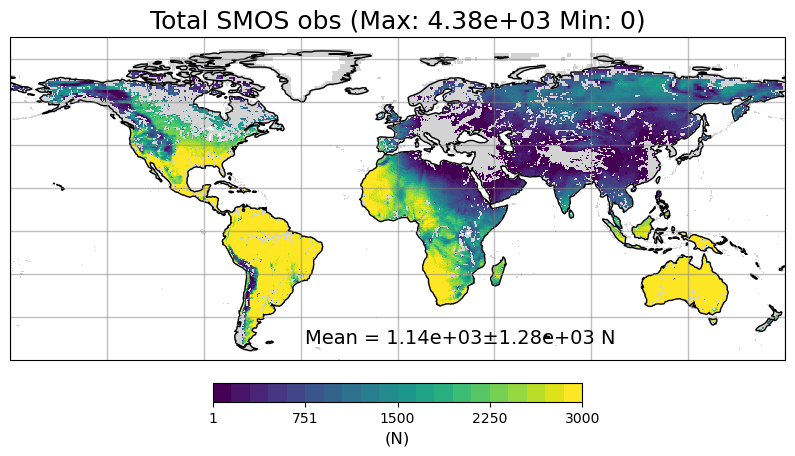

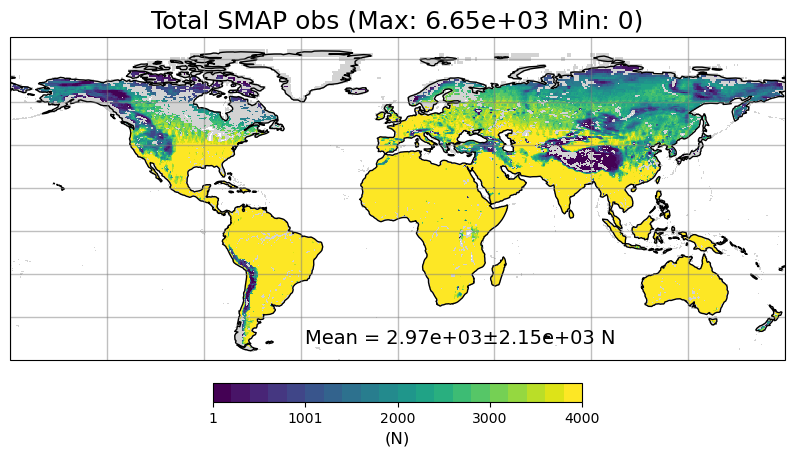

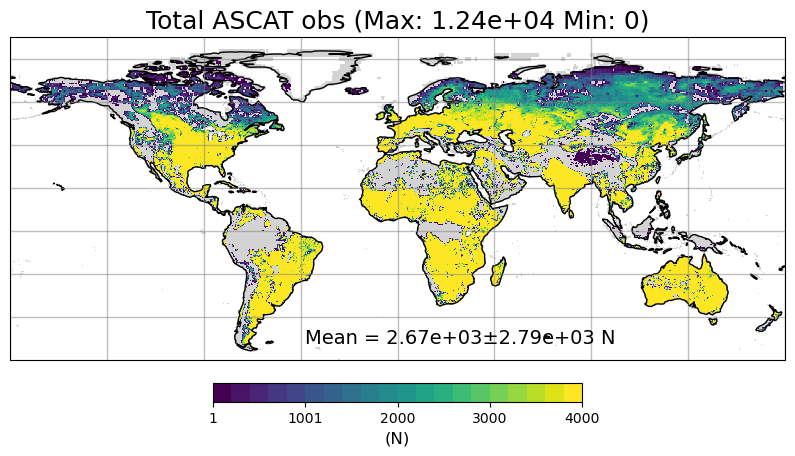

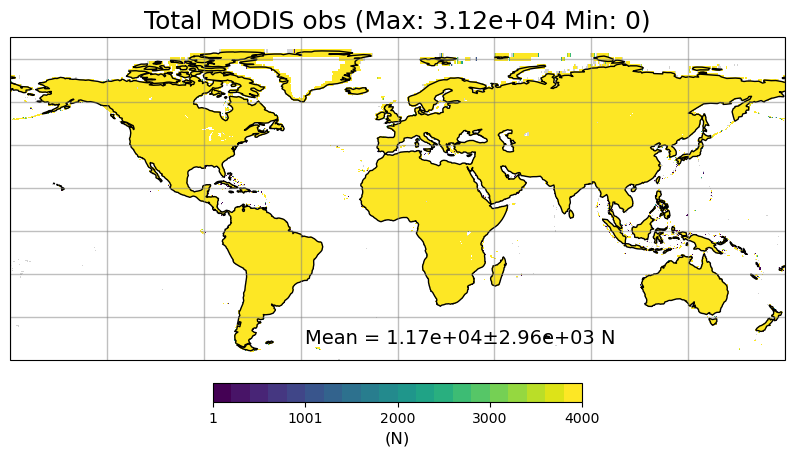

In [10]:
import xarray as xr
from mapper_functions import plot_global_tight_pcm

# Open the dataset for a specific file that contains lat/lon for M36 grid
ds_latlon = xr.open_dataset('DAv7_M36.inst3_1d_lndfcstana_Nt.20150901.nc4')

# Extract longitude and latitude variables
lon = ds_latlon['lon']
lat = ds_latlon['lat']

# Determine the number of tiles based on the latitude array
n_tile = len(lat)

# Initialize an observation array with NaN values
# The array has dimensions [n_tile, 3], where:
# - Column 0 is reserved for future use
# - Column 1 stores longitude values
# - Column 2 stores latitude values
map_array = np.empty([n_tile, 3])
map_array.fill(np.nan)
map_array[:, 1] = lon
map_array[:, 2] = lat

map_array[:, 0] = np.nansum(cumulative_obs_map[1:, 1:5], axis=1)

maxval = np.nanmax(map_array[:, 0]) 
minval = np.nanmin(map_array[:, 0]) 
plot_global_tight_pcm(map_array,False, True,f'Total SMOS obs (Max: {maxval:.3g} Min: {minval:.3g})','N', 1, 3000)


map_array[:, 0] = np.nansum(cumulative_obs_map[1:, 5:9], axis=1)

maxval = np.nanmax(map_array[:, 0]) 
minval = np.nanmin(map_array[:, 0]) 
plot_global_tight_pcm(map_array,False, True,f'Total SMAP obs (Max: {maxval:.3g} Min: {minval:.3g})','N', 1, 4000)


map_array[:, 0] = np.nansum(cumulative_obs_map[1:, 9:12], axis=1)

maxval = np.nanmax(map_array[:, 0]) 
minval = np.nanmin(map_array[:, 0]) 
plot_global_tight_pcm(map_array,False, True,f'Total ASCAT obs (Max: {maxval:.3g} Min: {minval:.3g})','N', 1, 4000)


map_array[:, 0] = np.nansum(cumulative_obs_map[1:, 12:14], axis=1)

maxval = np.nanmax(map_array[:, 0]) 
minval = np.nanmin(map_array[:, 0]) 
plot_global_tight_pcm(map_array,False, True,f'Total MODIS obs (Max: {maxval:.3g} Min: {minval:.3g})','N', 1, 4000)
